In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
# from simulations_util import *
from util import  apply_splitting_strategy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
pd.set_option('display.max_columns', None)

In [2]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'lightgrey'

In [ ]:
dgp = "linear"
combined_df = pd.DataFrame()
datasets = ["openml_361622", "openml_361260", "openml_361259", "openml_361253", "openml_361254", "openml_361242", "openml_361243"]
for data in datasets:
    ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_regression_{data}_{dgp}/{data}_{dgp}/varying_heritability_sample_row_n"
    feature_seeds = [1,2,3,4,5]
    sample_seeds = [1,2,3,4,5,6]
    for sample_seed in sample_seeds:
        for feature_seed in feature_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            df["dgp"] = dgp
            combined_df = pd.concat([combined_df, df], ignore_index=True)

dgp = "interaction"
for data in datasets:
    ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_regression_{data}_{dgp}/{data}_{dgp}/varying_heritability_sample_row_n"
    feature_seeds = [1,2,3,4,5]
    sample_seeds = [1,2,3,4,5,6]
    for sample_seed in sample_seeds:
        for feature_seed in feature_seeds:
            try:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except:
                pass

dgp = "linear_lss"
for data in datasets:
    ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_regression_{data}_{dgp}/{data}_{dgp}/varying_heritability_sample_row_n"
    feature_seeds = [1,2,3,4,5]
    sample_seeds = [1,2,3,4,5,6]
    for sample_seed in sample_seeds:
        for feature_seed in feature_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            df["dgp"] = dgp
            combined_df = pd.concat([combined_df, df], ignore_index=True)
            
df = combined_df.groupby(['sample_row_n', 'heritability', 'dgp', 'fi', 'data'])[["auroc_train", "auroc_test"]].mean().reset_index()

methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

# data_name = {
#     "openml_361260": "Miami Housing",
#     "openml_361622": "Cars",
#     "openml_361254": "SARCOS",
#     "openml_361259": "Puma Robot",
#     "openml_361253": "Wave Energy",
#     "openml_361242": "Super Conductivitity"
# }

data_name = {
    "openml_361622": "361622",
    "openml_361260": "361260",
    "openml_361259": "361259",
    "openml_361253": "361253",
    "openml_361254": "361254",
    "openml_361242": "361242",
    "openml_361243": "361243"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

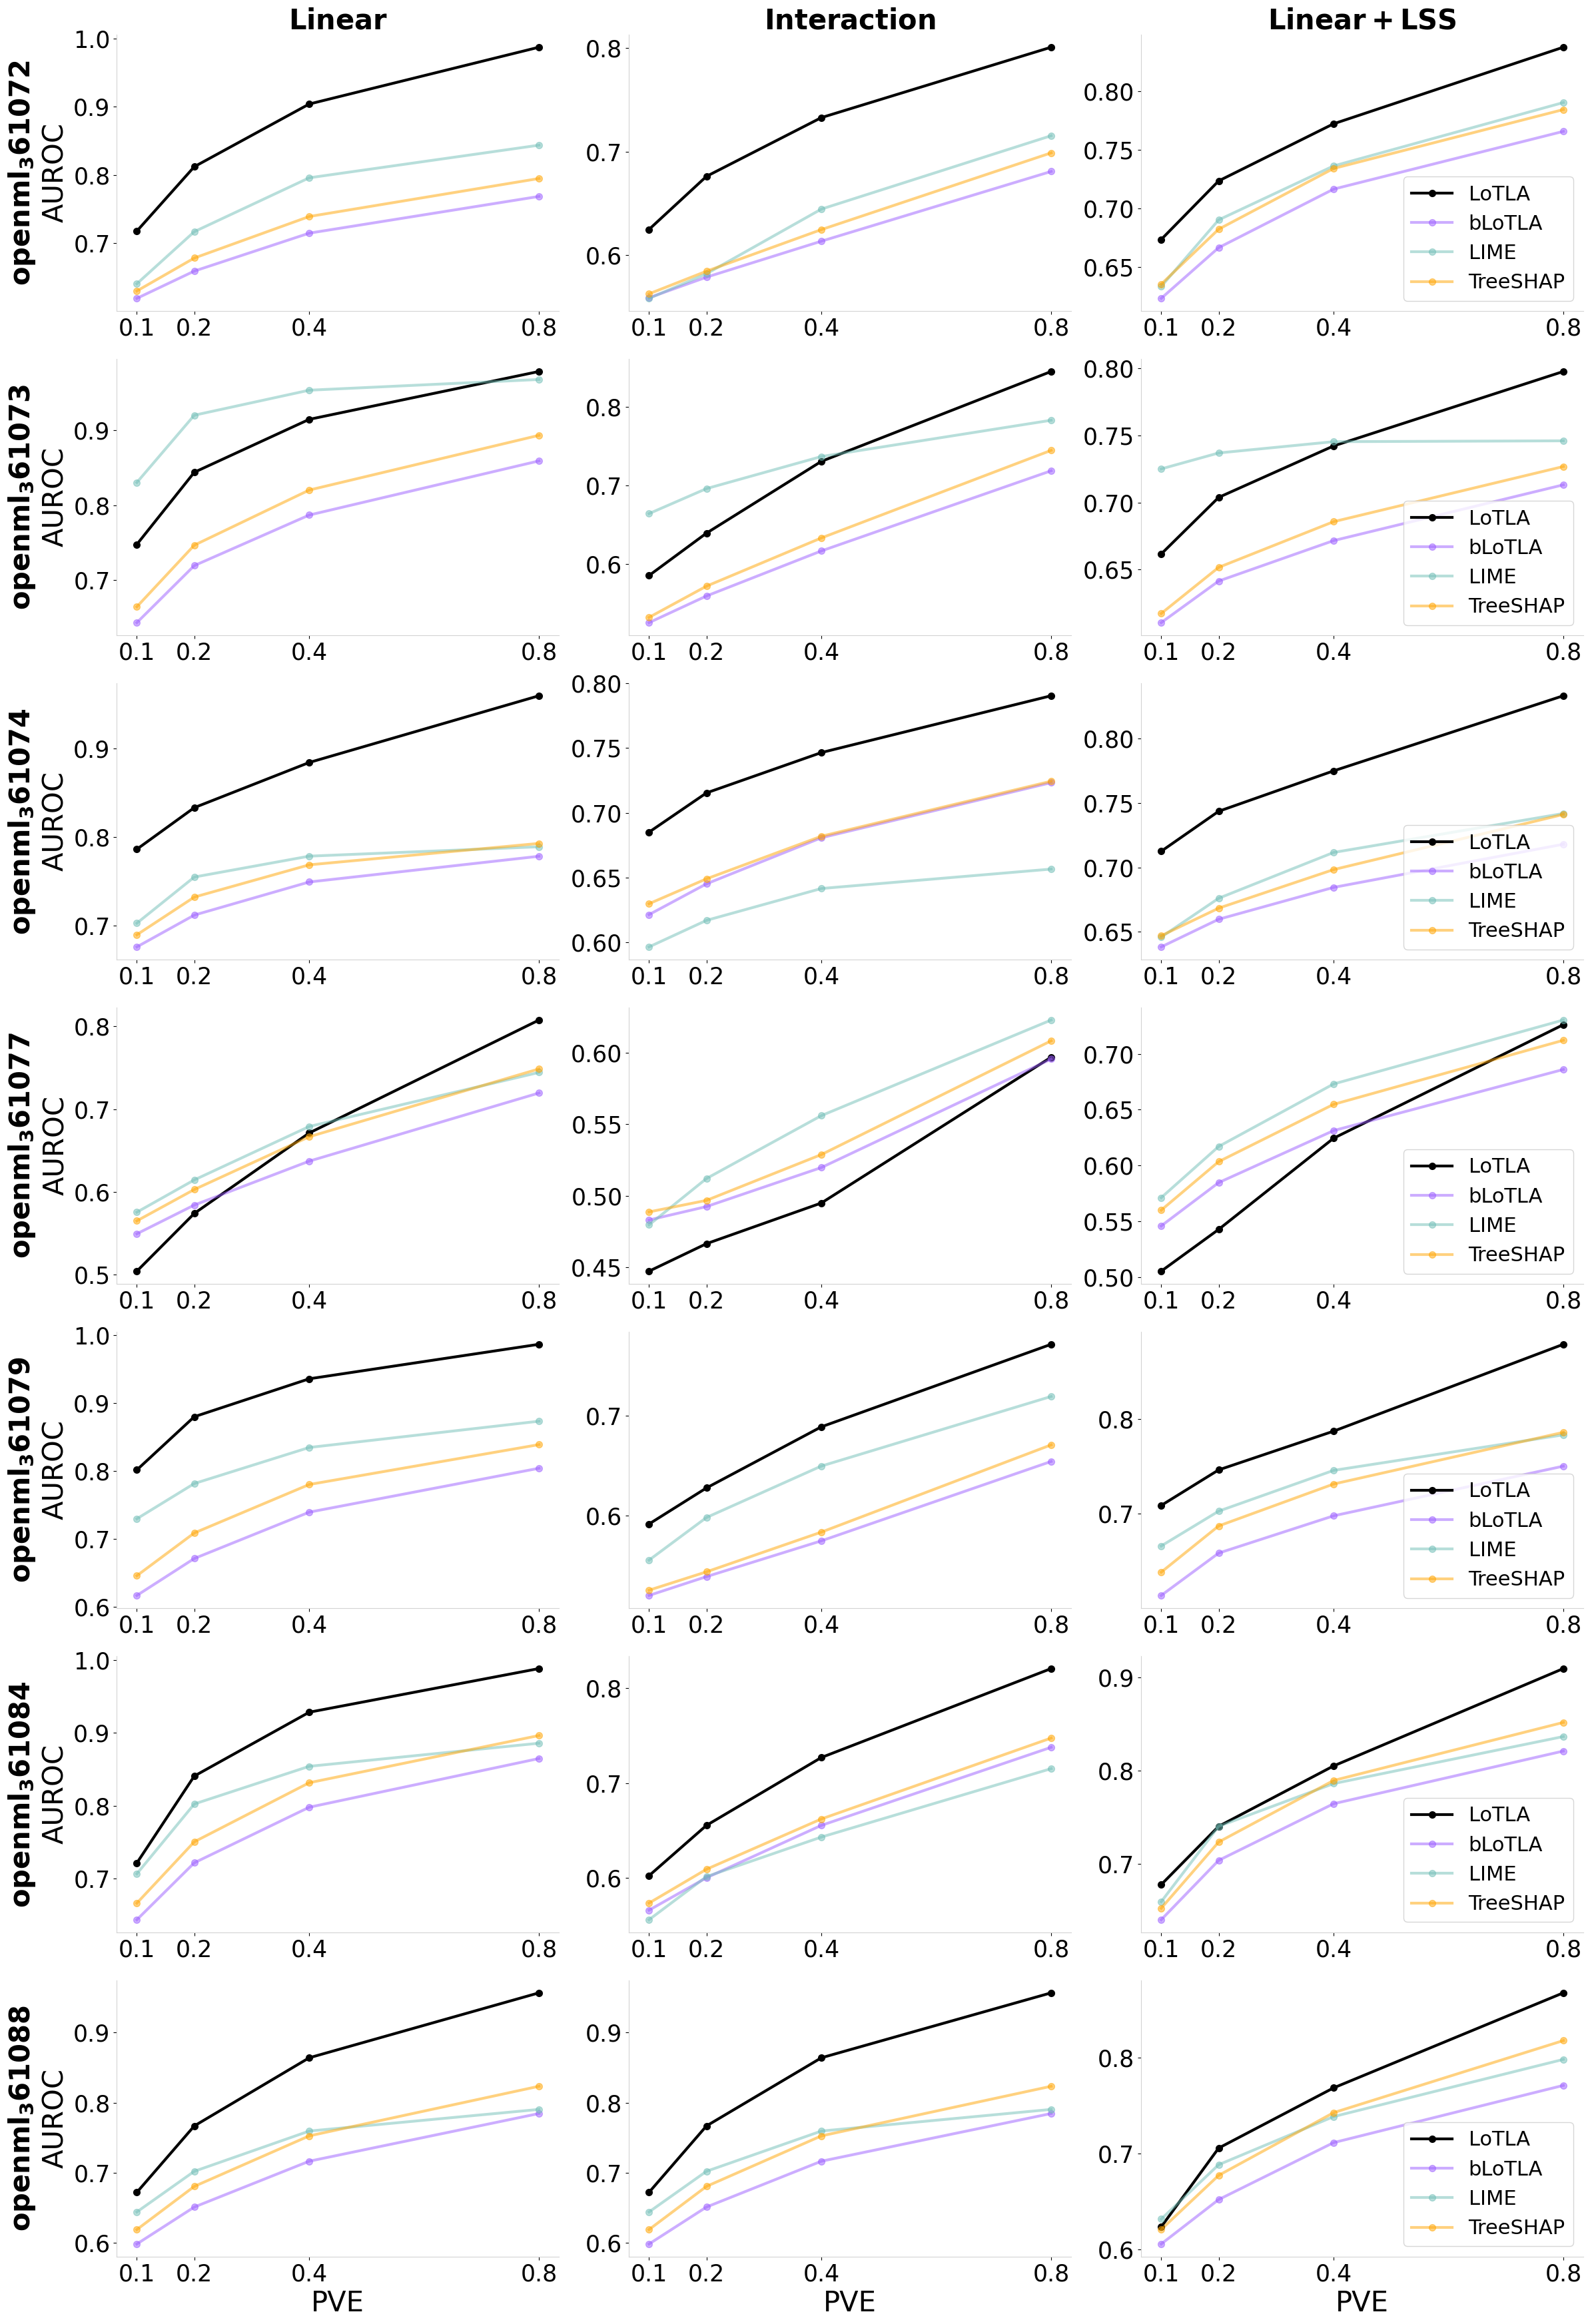

In [17]:
datasets = df["data"].unique()
dgp_all = ['linear', 'interaction', 'linear_lss']
marker_size = 7
df = df[df["sample_row_n"] == 1000]


# Number of columns is fixed (4 for PVE), number of rows is based on the number of datasets
n_cols = len(dgp_all) 
n_rows = len(datasets) 

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5 * n_rows),
    sharey=False  # Share y-axis across columns for easier comparison
)

# Ensure axs is 2D for easy indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Loop through each dataset (row) and PVE (column)
for row_idx, dataset in enumerate(datasets):
    for col_idx, data_generator in enumerate(dgp_all):
        ax = axs[row_idx, col_idx]
        subset = df[(df["data"] == dataset) & (df["dgp"] == data_generator)]
        
        # Plot results for each method
        for method in methods:
            method_data = subset[subset["fi"] == method]
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
                ax.plot(
                    method_data["heritability"], method_data['auroc_test'], 
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.plot(
                    method_data["heritability"], method_data['auroc_test'], 
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3
                )
        
        # Set x-axis labels and ticks
        ax.set_xticks([0.1, 0.2, 0.4, 0.8])
        ax.set_xticklabels(["0.1", "0.2", "0.4", "0.8"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if row_idx == n_rows - 1:  # Label x-axis only for the last row
            ax.set_xlabel("PVE", fontsize=30)
        
        # Set y-axis labels only for the first column
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=30)
        else:
            ax.set_ylabel("")
        
        # set this for the first row
        if row_idx == 0:
            data_generator_label_map = {
                'linear': 'Linear',
                'interaction': 'Interaction',
                'linear_lss': 'Linear + LSS'
            }
            ax.set_title(rf"$\bf{{{data_generator_label_map[data_generator]}}}$", fontsize=30)

        # Add legend to the last subplot of the row
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.suptitle(r"$\bf{Linear}$", fontsize=35)
# plt.suptitle(r"\textbf{Linear}", fontsize=40, usetex=True)
# plt.savefig("feature_ranking_vary_pve.png")
plt.show()

In [ ]:
dgp = "logistic_linear"
combined_df = pd.DataFrame()
datasets = ["openml_43", "openml_361062", "openml_361071", "openml_9978", "openml_361069", "openml_361068", "openml_361063"]
for data in datasets:
    ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_classification_{data}_{dgp}/{data}_{dgp}/varying_frac_label_corruption_sample_row_n"
    feature_seeds = [1,2,3,4,5]
    sample_seeds = [1,2,3,4,5,6]
    for sample_seed in sample_seeds:
        for feature_seed in feature_seeds:
            try:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except:
                pass

dgp = "logistic_interaction"
for data in datasets:
    ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_classification_{data}_{dgp}/{data}_{dgp}/varying_frac_label_corruption_sample_row_n"
    feature_seeds = [1,2,3,4,5]
    sample_seeds = [1,2,3,4,5,6]
    for sample_seed in sample_seeds:
        for feature_seed in feature_seeds:
            try:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except:
                pass


dgp = "logistic_linear_lss"
for data in datasets:
    ablation_directory = f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_classification_{data}_{dgp}/{data}_{dgp}/varying_frac_label_corruption_sample_row_n"
    feature_seeds = [1,2,3,4,5]
    sample_seeds = [1,2,3,4,5,6]
    for sample_seed in sample_seeds:
        for feature_seed in feature_seeds:
            try:
                df = pd.read_csv(os.path.join(ablation_directory, f"seed_{feature_seed}_{sample_seed}/results.csv"))
                df["data"] = data
                df["dgp"] = dgp
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except:
                pass
            
df = combined_df.groupby(['sample_row_n', 'frac_label_corruption', 'dgp', 'fi', 'data'])[["auroc_train", "auroc_test"]].mean().reset_index()

methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

# data_name = {
#     "openml_43": "Spam",
#     "openml_9946": "Breast Cancer",
#     "openml_9978": "Ozone",
#     "openml_146819": "Climate",
#     "openml_361062": "Pol",
#     "openml_361070": "Eye Movement"
# }

data_name = {
    "openml_43": "43",
    "openml_361062": "361062",
    "openml_361071": "361071",
    "openml_9978": "9978",
    "openml_361069": "361069",
    "openml_361068": "361068",
    "openml_361063": "361063"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

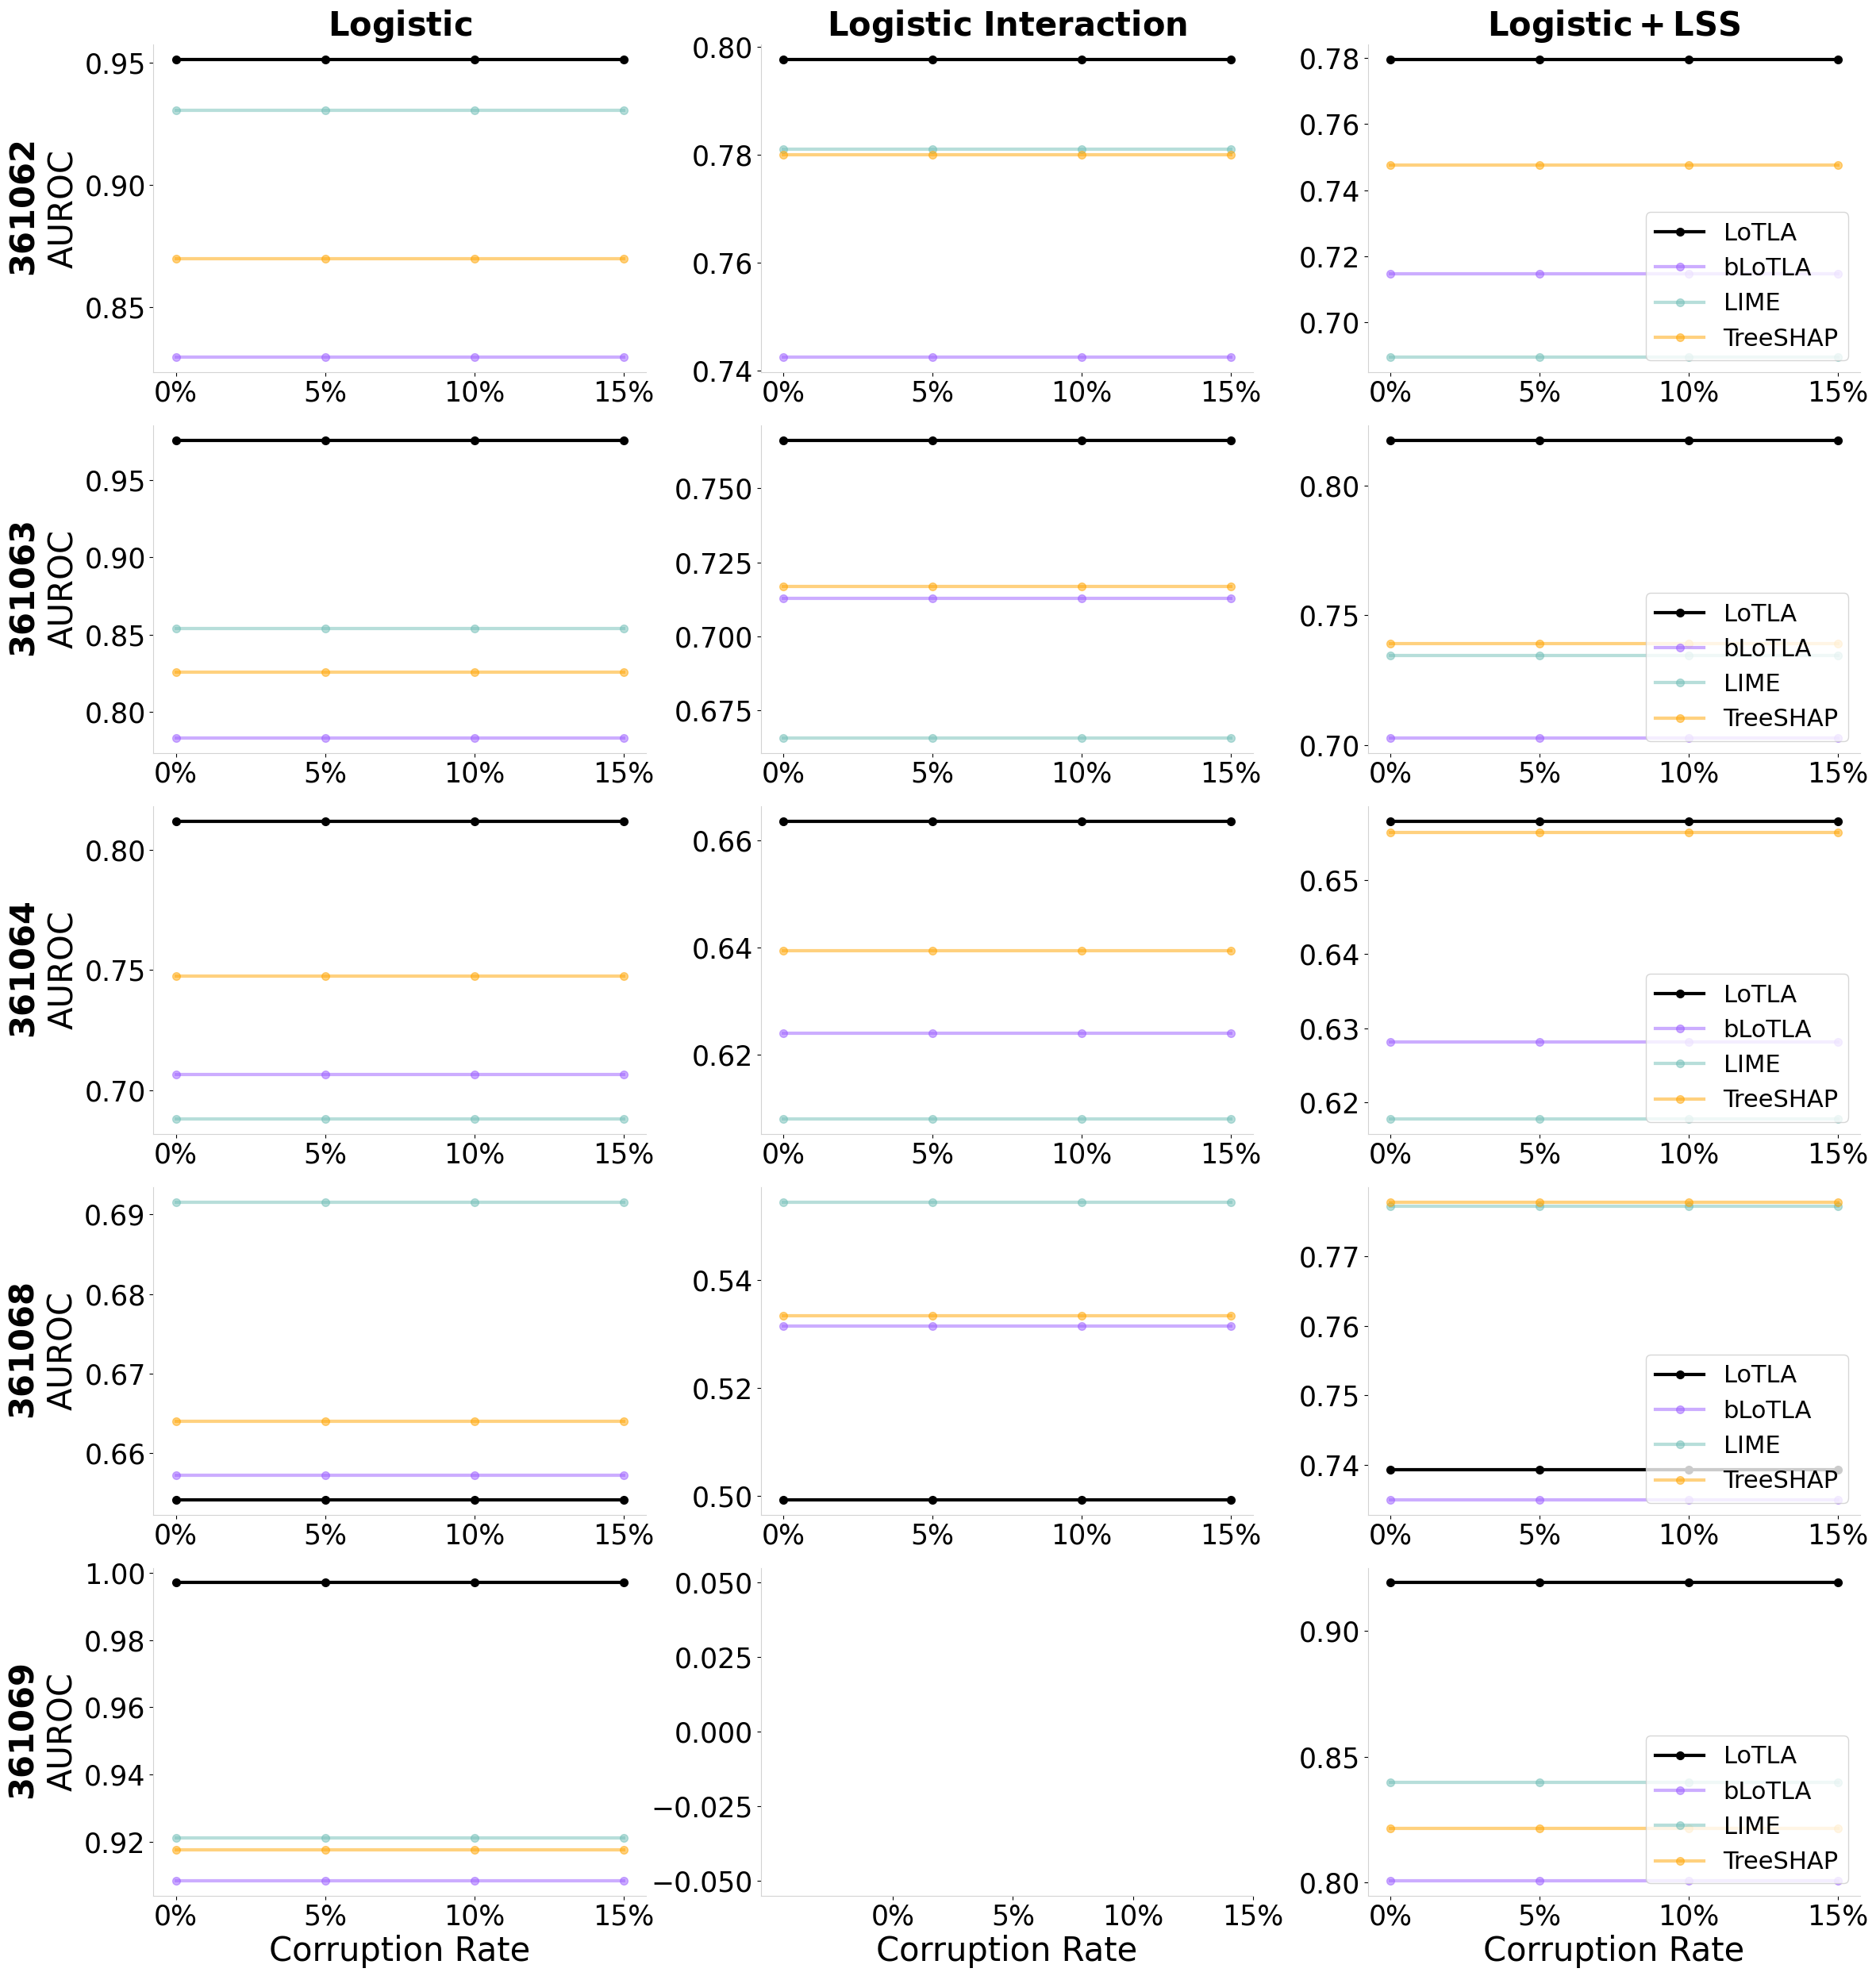

In [6]:
datasets = df["data"].unique()
dgp_all = ['logistic_linear', 'logistic_interaction', 'logistic_linear_lss']
marker_size = 7
df = df[df["sample_row_n"] == 1000]

# Number of columns is fixed (4 for PVE), number of rows is based on the number of datasets
n_cols = len(dgp_all)  # One column per PVE
n_rows = len(datasets)          # One row per dataset

# Create subplots
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5 * n_rows),
    sharey=False  # Share y-axis across columns for easier comparison
)

# Ensure axs is 2D for easy indexing
if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# Loop through each dataset (row) and PVE (column)
for row_idx, dataset in enumerate(datasets):
    for col_idx, data_generator in enumerate(dgp_all):
        ax = axs[row_idx, col_idx]
        subset = df[(df["data"] == dataset) & (df["dgp"] == data_generator)]
        
        # Plot results for each method
        for method in methods:
            method_data = subset[subset["fi"] == method]
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
                ax.plot(
                    method_data["frac_label_corruption"], method_data['auroc_test'], 
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.plot(
                    method_data["frac_label_corruption"], method_data['auroc_test'], 
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3
                )
        
        # Set x-axis labels and ticks
        ax.set_xticks([0,0.05, 0.1, 0.15])
        ax.set_xticklabels(["0%", "5%", "10%", "15%"], fontsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if row_idx == n_rows - 1:  # Label x-axis only for the last row
            ax.set_xlabel("Corruption Rate", fontsize=30)
        
        # Set y-axis labels only for the first column
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=30)
        else:
            ax.set_ylabel("")
        
        # set this for the first row
        if row_idx == 0:
            data_generator_label_map = {
                'logistic_linear': 'Logistic',
                'logistic_interaction': 'Logistic \\ Interaction',
                'logistic_linear_lss': 'Logistic +  LSS'
            }
            ax.set_title(rf"$\bf{{{data_generator_label_map[data_generator]}}}$", fontsize=30)

        # Add legend to the last subplot of the row
        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.suptitle(r"$\bf{Linear}$", fontsize=35)
# plt.suptitle(r"\textbf{Linear}", fontsize=40, usetex=True)
# plt.savefig("feature_ranking_vary_corruption.png")
plt.show()